此项目为Youtube视频（美区）数据集的频繁模式和关联规则挖掘


导入pandas、mlxtend等数据挖掘工具，导入原始数据：

In [54]:
import os
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
os.chdir("C:\\Users\\acer_pc\\Downloads\\youtube-new")
data = pd.read_csv("USvideos.csv")



显示数据前5行，查看数据样式：

In [6]:
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...




剔除缺失值，并计算各数值类型数据的五数概括：

In [26]:
data.dropna()
data.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06




箱线图展示：

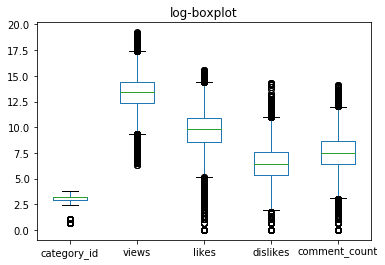

In [27]:
df = pd.DataFrame(data[['category_id','views','likes','dislikes','comment_count']])
np.log(1+df).plot.box(title="log-boxplot")
 
# plt.grid(linestyle="--", alpha=0.3)
plt.show()



我们要挖掘Youtube数据中的频繁模式和关联规则，但数据集中没有可以直接拿来挖掘的模式，因此需要根据数据特点自己制定模式（标签）。
根据箱线图，我们可以将观看数views、点赞数likes、点踩数dislikes以及评论数comment_count按照数量多少分别划分为4个等级：
很少，较少，较多，很多。并分别编码为_0，_1，_2，_3。
不同等级之间的边界采用各自属性的四分位数和中位数。

In [44]:
describe = df.describe()
df_encode = df.copy()

df_encode.loc[df.views>=describe['views']['75%'],'views'] = 'views_3'
df_encode.loc[(df.views<describe['views']['75%']) & (df.views>=describe['views']['50%']),'views'] = 'views_2'
df_encode.loc[(df.views<describe['views']['50%']) & (df.views>=describe['views']['25%']),'views'] = 'views_1'
df_encode.loc[df.views<describe['views']['25%'],'views'] = 'views_0'

df_encode.loc[df.likes>=describe['likes']['75%'],'likes'] = 'likes_3'
df_encode.loc[(df.likes<describe['likes']['75%']) & (df.likes>=describe['likes']['50%']),'likes'] = 'likes_2'
df_encode.loc[(df.likes<describe['likes']['50%']) & (df.likes>=describe['likes']['25%']),'likes'] = 'likes_1'
df_encode.loc[df.likes<describe['likes']['25%'],'likes'] = 'likes_0'

df_encode.loc[df.dislikes>=describe['dislikes']['75%'],'dislikes'] = 'dislikes_3'
df_encode.loc[(df.dislikes<describe['dislikes']['75%']) & (df.dislikes>=describe['dislikes']['50%']),'dislikes'] = 'dislikes_2'
df_encode.loc[(df.dislikes<describe['dislikes']['50%']) & (df.dislikes>=describe['dislikes']['25%']),'dislikes'] = 'dislikes_1'
df_encode.loc[df.dislikes<describe['dislikes']['25%'],'dislikes'] = 'dislikes_0'

df_encode.loc[df.comment_count>=describe['comment_count']['75%'],'comment_count'] = 'comment_count_3'
df_encode.loc[(df.comment_count<describe['comment_count']['75%']) & (df.comment_count>=describe['comment_count']['50%']),'comment_count'] = 'comment_count_2'
df_encode.loc[(df.comment_count<describe['comment_count']['50%']) & (df.comment_count>=describe['comment_count']['25%']),'comment_count'] = 'comment_count_1'
df_encode.loc[df.comment_count<describe['comment_count']['25%'],'comment_count'] = 'comment_count_0'

以此将数据编码（分类）后，下面来挖掘不同属性的不同等级之间的频繁模式和关联规则


首先将等级数据进行one-hot编码，然后利用Apriori算法挖掘其频繁模式：
这里取最小支持度为1/16

In [52]:
te = TransactionEncoder()
#进行 one-hot 编码
te_ary = te.fit(df_encode.values.tolist()).transform(df_encode.values.tolist())
cod = pd.DataFrame(te_ary, columns=te.columns_)
#利用 Apriori 找出频繁项集
freq = apriori(cod, min_support=0.0625, use_colnames=True)
print(freq)

     support                                         itemsets
0   0.158050                                             (10)
1   0.078390                                             (22)
2   0.084422                                             (23)
3   0.243327                                             (24)
4   0.101248                                             (26)
5   0.249921                                (comment_count_0)
6   0.249994                                (comment_count_1)
7   0.250043                                (comment_count_2)
8   0.250043                                (comment_count_3)
9   0.249383                                     (dislikes_0)
10  0.250409                                     (dislikes_1)
11  0.250140                                     (dislikes_2)
12  0.250067                                     (dislikes_3)
13  0.249994                                        (likes_0)
14  0.249994                                        (likes_1)
15  0.24

上述结果中右侧为频繁项集，左侧为对应的支持度


继续挖掘频繁项集的关联规则，可以得出不同关联规则的置信度以及lift、leverage、conviction评价：
这里取最小置信度为80%

In [66]:
rules = association_rules(freq, metric="confidence", min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(likes_3, 10)",(views_3),0.082957,0.250018,0.066668,0.803650,3.214366,0.045928,3.819622
1,"(10, views_3)",(likes_3),0.071870,0.250018,0.066668,0.927625,3.710228,0.048700,10.362423
2,"(dislikes_3, likes_3)",(comment_count_3),0.172385,0.250043,0.156976,0.910611,3.641820,0.113872,8.389775
3,"(dislikes_3, comment_count_3)",(likes_3),0.182056,0.250018,0.156976,0.862240,3.448708,0.111458,5.444122
4,"(comment_count_0, likes_0, dislikes_0)",(views_0),0.160053,0.249994,0.140394,0.877174,3.508783,0.100382,6.106261
5,"(comment_count_0, likes_0, views_0)",(dislikes_0),0.159442,0.249383,0.140394,0.880533,3.530841,0.100632,6.283046
6,"(comment_count_0, dislikes_0, views_0)",(likes_0),0.154900,0.249994,0.140394,0.906353,3.625502,0.101670,8.008904
7,"(likes_0, dislikes_0, views_0)",(comment_count_0),0.149943,0.249921,0.140394,0.936319,3.746466,0.102920,11.778740
8,"(likes_0, dislikes_0)","(comment_count_0, views_0)",0.173728,0.179247,0.140394,0.808125,4.508434,0.109254,4.277534
9,"(likes_3, comment_count_3)",(views_3),0.201592,0.250018,0.167013,0.828468,3.313628,0.116611,4.372245


左侧两行分别为关联规则的先导和后继，从总体上可以看出“较多”与“很少”数量等级的各属性数目之间的关联度较大，
且视频类别10的点赞数、观看数、评论数在“较多”这个等级上关联度较强，进而推断类别10的视频比较受欢迎。



Lift评价：
选取上述结果中lift>3的关联规则，并按照lift值降序排列

In [69]:
rules[ (rules['lift'] >= 3)].sort_values("lift",ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
22,"(dislikes_3, likes_3)","(comment_count_3, views_3)",0.172385,0.180322,0.145913,0.846437,4.694035,0.114828,5.337738
24,"(comment_count_3, views_3)","(dislikes_3, likes_3)",0.180322,0.172385,0.145913,0.809182,4.694035,0.114828,4.337195
8,"(likes_0, dislikes_0)","(comment_count_0, views_0)",0.173728,0.179247,0.140394,0.808125,4.508434,0.109254,4.277534
23,"(dislikes_3, comment_count_3)","(likes_3, views_3)",0.182056,0.191677,0.145913,0.801476,4.181376,0.111017,4.071652
31,"(10, comment_count_3)",(likes_3),0.065643,0.250018,0.064519,0.982887,3.931260,0.048107,43.825017
7,"(likes_0, dislikes_0, views_0)",(comment_count_0),0.149943,0.249921,0.140394,0.936319,3.746466,0.102920,11.778740
18,"(dislikes_3, likes_3, comment_count_3)",(views_3),0.156976,0.250018,0.145913,0.929527,3.717836,0.106666,10.642124
20,"(dislikes_3, comment_count_3, views_3)",(likes_3),0.157073,0.250018,0.145913,0.928949,3.715524,0.106642,10.555541
1,"(10, views_3)",(likes_3),0.071870,0.250018,0.066668,0.927625,3.710228,0.048700,10.362423
11,"(comment_count_3, views_3)",(likes_3),0.180322,0.250018,0.167013,0.926192,3.704496,0.121929,10.161220





conviction评价：
选取上述结果中conviction>10的关联规则，并按照conviction值降序排列

In [70]:
rules[ (rules['conviction'] >= 10)].sort_values("conviction",ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,"(10, comment_count_3)",(likes_3),0.065643,0.250018,0.064519,0.982887,3.931260,0.048107,43.825017
7,"(likes_0, dislikes_0, views_0)",(comment_count_0),0.149943,0.249921,0.140394,0.936319,3.746466,0.102920,11.778740
18,"(dislikes_3, likes_3, comment_count_3)",(views_3),0.156976,0.250018,0.145913,0.929527,3.717836,0.106666,10.642124
20,"(dislikes_3, comment_count_3, views_3)",(likes_3),0.157073,0.250018,0.145913,0.928949,3.715524,0.106642,10.555541
1,"(10, views_3)",(likes_3),0.071870,0.250018,0.066668,0.927625,3.710228,0.048700,10.362423
11,"(comment_count_3, views_3)",(likes_3),0.180322,0.250018,0.167013,0.926192,3.704496,0.121929,10.161220




可视化：
下列可视化结果分别为支持度、置信度、lift评价、conviction评价的箱线图

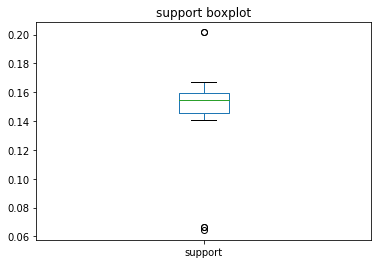

In [92]:
rules['support'].plot.box(title="support boxplot")
# plt.ylim(0.24975,0.2501)
# plt.grid(linestyle="--", alpha=0.3)
plt.show()

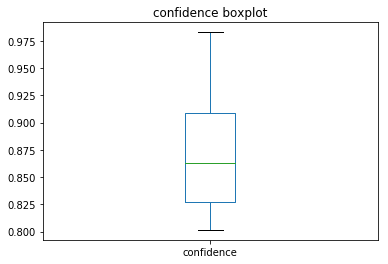

In [91]:
rules['confidence'].plot.box(title="confidence boxplot")
# plt.ylim(0.24975,0.2501)
# plt.grid(linestyle="--", alpha=0.3)
plt.show()

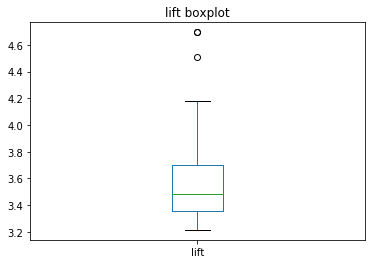

In [93]:
rules['lift'].plot.box(title="lift boxplot")
# plt.ylim(0.24975,0.2501)
# plt.grid(linestyle="--", alpha=0.3)
plt.show()

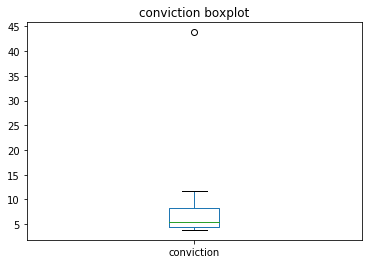

In [94]:
rules['conviction'].plot.box(title="conviction boxplot")
# plt.ylim(0.24975,0.2501)
# plt.grid(linestyle="--", alpha=0.3)
plt.show()